# Imports e classes


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import time
import random

# --- CLASSE PID ---
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err: list):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.err = err # Referencia para a lista externa
        self.integral = 0.0
        self.last_error = 0.0
        self.time_init = True

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value

        # Termo Proporcional
        P_term = self.Kp * error

        # Termo Integral
        if not self.time_init:
            self.integral += error * self.dt
            I_term = self.Ki * self.integral
        else:
            I_term = 0.0
            self.time_init = False

        # Termo Derivativo
        derivative = (error - self.last_error) / self.dt
        D_term = self.Kd * derivative

        self.last_error = error

        # Salva o erro na lista externa
        self.err.append(error)

        u = P_term + I_term + D_term
        return u

class Metrics:
  def __init__(self, err: list):
    self.err = err

  def mae(self, err: list) -> float:
      return np.mean(np.abs(err))

  def itae(self, err: list, t: np.ndarray) -> float:
      return (np.mean(np.abs(err) * t))

  def mse(self, err: list) -> float:
      return np.mean(np.square(err))

  def _epsilon1(self, SC_k: list) -> float:
      return np.mean(SC_k)

  def _epsilon2(self, SC_k: list, eps_1) -> float:
      result = []
      for i in range(len(SC_k)):
        result.append(np.square(SC_k[i] - eps_1))
      return np.mean(result)

  def _epsilon3(self, err: list) -> float:
      return self.mse(err)

  def goodhart_index(self, c1: float, c2: float, c3: float, SC_k: list)-> float:
      first_idx = c1 * self._epsilon1(SC_k)
      second_idx = c2 * self._epsilon2(SC_k, self._epsilon1(SC_k))
      third_idx = c3 * self._epsilon3(self.err)

      bom_coracao = first_idx + second_idx + third_idx
      return bom_coracao

## Código original


Starting motor simulation (Original Control).

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1
Max ref: 0.9999999999931224
Min ref: -0.9999999999993656
Max ref: 1.0
Min ref: -0.9999999999966656

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 21.589262008666992 sec.

--- SIMULATION Finished. --.



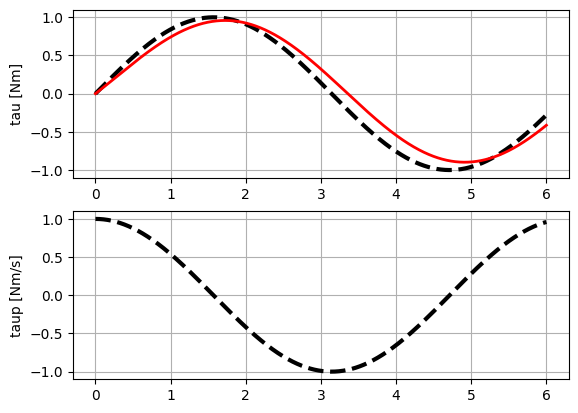

Simulação Original Concluída.


In [ ]:
# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"

print("Starting motor simulation (Original Control).")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1
SC_k_1 = [] # Global list for control actions
err_1 = [] # Global list for errors

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
# This function defines the derivatives of the states for odeint
def connected_systems_model(states, t, dc_volts_input):
    # states is [x1_m, some_dummy_value]
    x1_m, _ = states # x1_m is the torque (tau)

    # Compute motor torque derivative
    taup = dc_motor_model(x1_m, dc_volts_input)

    # Output: derivatives of the states
    # taup is the derivative of x1_m
    # 0.0 is the derivative of the dummy second state
    out_states_derivatives = [taup, 0.0]
    return out_states_derivatives


# Initial conditions
states0 = [0, 0] # Initial states: [tau, dummy_value]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
torque_ref = np.sin(time_vector)
print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
torquep_ref = np.cos(time_vector)
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))

# Output arrays
states_1 = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
current_tau = states0[0] # Initialize current_tau for controller

SC_k_1 = [] # Ensure it's empty for this simulation
err_1 = [] # Ensure it's empty for this simulation

for i in range(n-1):
    # Calculate dc_volts using the motor controller
    dc_volts = motor_controller(current_tau, torque_ref[i], torquep_ref[i])
    SC_k_1.append(dc_volts) # Store control action once per step

    # Integrate the system using odeint
    # Pass the calculated dc_volts as an argument to the system model
    out_states_integrated = odeint(connected_systems_model, states0, [0.0, tf/n],
                                   args=(dc_volts,)) # Pass dc_volts_input

    states0 = out_states_integrated[-1,:] # Update current states for next iteration
    states_1[i] = out_states_integrated[-1,:] # Store the final states for this step
    current_tau = states0[0] # Update current_tau based on the integrated state

    # Calculate error
    err_1.append(torque_ref[i] - states_1[i,0])

    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. --.\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states_1)
    sim_df = sim_df.transpose()
    # sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
    #                3: 'dc_volts'}, inplace=True) # This renaming mapping might be wrong after changes
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states_1[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

print("Simulação Original Concluída.")

## Sinal de entrada com adição de ruído

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"

print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations

torque_ref = np.sin(time_vector + math.pi/3)
print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
torquep_ref = np.cos(time_vector + math.pi/3)
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

Starting motor simulation.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1
Max ref: 0.9999999999978012
Min ref: -0.9999999999890513
Max ref: 0.9999999999995289
Min ref: -0.9999999999987012

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%


## Sinal de entrada sendo constante

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 10.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"

print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
constant_torque_value = 0.5
torque_ref = np.full_like(time_vector, constant_torque_value)
torquep_ref = np.full_like(time_vector, 0.0)


print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

## Sinal de entrada sendo rampa

In [ ]:
def ramp(x):
    return np.maximum(0, x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"
print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
torque_ref = ramp(time_vector)
torquep_ref = np.where(time_vector > 0, 1.0, 0.0)

print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

## Alterando o controlador para um PID

Starting motor simulation with PID controller.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller PID: Kp=20.0, Ki=15.0, Kd=0.5

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 0.01
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%

Elapsed time: 0.035184383392333984 sec.

--- SIMULATION Finished. ---



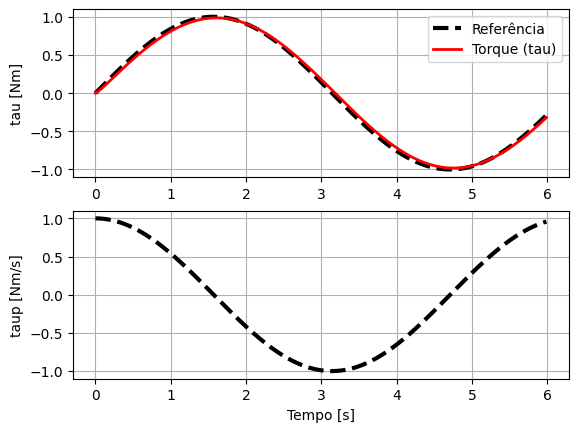

In [ ]:
# Simulation parametrs
tf = 6.0  # final time
ts_ms = 10.0   # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_PID"

print("Starting motor simulation with PID controller.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
err_2 = []
# Motor Controller (PID)
Kp = 20.0
Ki = 15.0
Kd = 0.5

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller PID: Kp={}, Ki={}, Kd={}".format(Kp, Ki, Kd))

SC_k_2 = []

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    dx1_m = -(a+a_model_error)*(k+k_model_error)*x1_m + (k+k_model_error)*u

    y1_m = x1_m
    return dx1_m

def connected_systems_model(states, t, dc_volts):
    # Valores de entrada. O primeiro estado é o torque (tau)
    x1_m, _ = states

    # Calcula o torque do motor
    taup = dc_motor_model(x1_m, dc_volts)

    # Saída
    # out_states = [taup, dc_volts]
    out_states = [taup, 0.0]
    return out_states

states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1)

time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

pid_controller = PIDController(Kp, Ki, Kd, t_sim_step, err_2)

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

states_2 = np.zeros( (n-1, len(states0)) )

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
t_counter = 0

current_tau = states0[0]

for i in range(n-1):
    tau_ref_i = torque_ref[i]

    dc_volts = pid_controller.calculate_control_action(tau_ref_i, current_tau)

    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(dc_volts,))

    SC_k_2.append(dc_motor_model(states0[0], dc_volts))

    states0 = out_states[-1,:]
    states_2[i] = out_states[-1,:]
    current_tau = states0[0]

    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

# Plot results
plt.rcParams['axes.grid'] = True
plt.figure()

# Plot do Torque (Tau)
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3, label='Referência')
plt.plot(time_vector[:-1],states_2[:,0],'r',linewidth=2, label='Torque (tau)')
plt.ylabel('tau [Nm]')
plt.legend()

# Plot da Tensão CC (dc_volts) - Apenas plotamos a referência aqui,
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3, label='Tau_p Ref')
plt.ylabel('taup [Nm/s]')
plt.xlabel('Tempo [s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

# Aula 2

- Desenvolver sistema de controle baseado em erro.
- Métricas a serem consideradas são
- IAE/MAE
- ITAE
- ISE/MSE
- Índice de Goodhart

## Pegando valores das métricas

In [ ]:
metrics_ORIGINAL = Metrics(err_1)
mae_ORIGINAL = metrics_ORIGINAL.mae(err_1)
t_for_itae = time_vector[:-1]
itae_ORIGINAL = metrics_ORIGINAL.itae(err_1, t_for_itae)
mse_ORIGINAL = metrics_ORIGINAL.mse(err_1)
goodhart_index_ORIGINAL = metrics_ORIGINAL.goodhart_index(0.33, 0.33, 0.34, SC_k_1)

print("\n--- METRICS ORIGINAL ---\n")
print("MAE ORIGINAL: {}".format(mae_ORIGINAL))
print("ITAE ORIGINAL: {}".format(itae_ORIGINAL))
print("MSE ORIGINAL: {}".format(mse_ORIGINAL))
print("Goodhart Index ORIGINAL: {}".format(goodhart_index_ORIGINAL))

NameError: name 'err_1' is not defined

In [ ]:
metrics_PID = Metrics(err_2)
mae_PID = metrics_PID.mae(err_2)
t = time_vector[:-1]
itae_PID = metrics_PID.itae(err_2, t)
mse_PID = metrics_PID.mse(err_2)
goodhart_index_PID = metrics_PID.goodhart_index(0.33, 0.33, 0.34, SC_k_2)
print("\n---METRICS PID---\n")
print("MAE PID: {}".format(mae_PID))
print("ITAE PID: {}".format(itae_PID))
print("MSE PID: {}".format(mse_PID))
print("Goodhart Index PID: {}".format(goodhart_index_PID))


---METRICS PID---

MAE PID: 0.03130415919606606
ITAE PID: 0.09076544362401945
MSE PID: 0.0012239935203675883
Goodhart Index PID: 0.13290487140560214


Comparação dos dois controladores com o erro

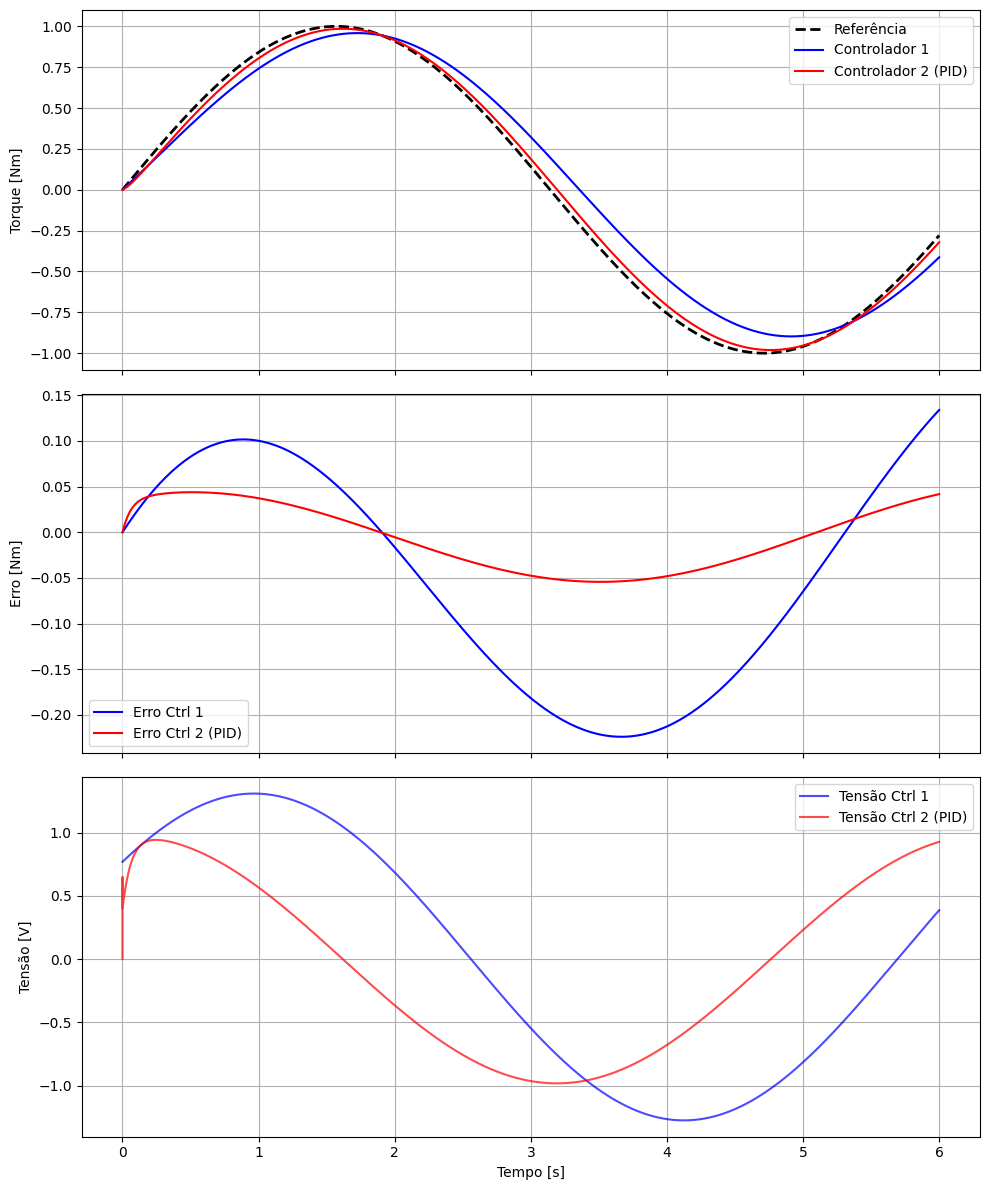

Métrica         | Controlador ORIGINAL | Controlador (PID)
--------------------------------------------------
MAE             | 0.108905        | 0.031358
ITAE            | 0.355894        | 0.091083
MSE             | 0.016388        | 0.001228
Goodhart        | 0.286004        | 0.130009


In [ ]:


metrics_PID = {
    "MAE": mae_PID,
    "ITAE": itae_PID,
    "MSE": mse_PID,
    "Goodhart": goodhart_index_PID
}


metrics_ORIGINAL = {
    "MAE": mae_ORIGINAL,
    "ITAE": itae_ORIGINAL,
    "MSE": mse_ORIGINAL,
    "Goodhart": goodhart_index_ORIGINAL
}

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador 1')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label='Controlador 2 (PID)')
axs[0].set_ylabel('Torque [Nm]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro Ctrl 2 (PID)')
axs[1].set_ylabel('Erro [Nm]')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.7)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão Ctrl 2 (PID)', alpha=0.7)
axs[2].set_ylabel('Tensão [V]')
axs[2].set_xlabel('Tempo [s]')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print(f"{'Métrica':<15} | {'Controlador ORIGINAL':<15} | {'Controlador (PID)':<15}")
print("-" * 50)
for k in metrics_ORIGINAL:
    print(f"{k:<15} | {metrics_ORIGINAL[k]:.6f}        | {metrics_PID[k]:.6f}")

# Algoritmo genético

 OTIMIZAÇÃO PID COM ALGORITMO GENÉTICO

--- PARÂMETROS DO SISTEMA ---
Motor: a = 1, k = 1
Erros de modelagem: a_error = 0.1, k_error = 0.3

PID INICIAL: Kp = 20.0, Ki = 15.0, Kd = 0.5

 INICIANDO ALGORITMO GENÉTICO
População: 30 indivíduos
Gerações: 20
Taxa de mutação: 20.0%
Indivíduo inicial: Kp=20.0, Ki=15.0, Kd=0.5

--- EVOLUÇÃO ---

Geração  1: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  2: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  3: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  4: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  5: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  6: Score=0.1144 | Kp=12.43, Ki=1.97, Kd=0.48
Geração  7: Score=0.1077 | Kp=8.23, Ki=3.21, Kd=0.46
Geração  8: Score=0.1077 | Kp=8.23, Ki=3.21, Kd=0.46
Geração  9: Score=0.1077 | Kp=8.23, Ki=3.21, Kd=0.46
Geração 10: Score=0.1077 | Kp=8.23, Ki=3.21, Kd=0.46
Geração 11: Score=0.1077 | Kp=8.23, Ki=3.21, Kd=0.46
Geração 12: Score=0.1072 | Kp=8.04, Ki=3.21, Kd=0.47
Geração 13: Score=0

NameError: name 'inicial_vals' is not defined

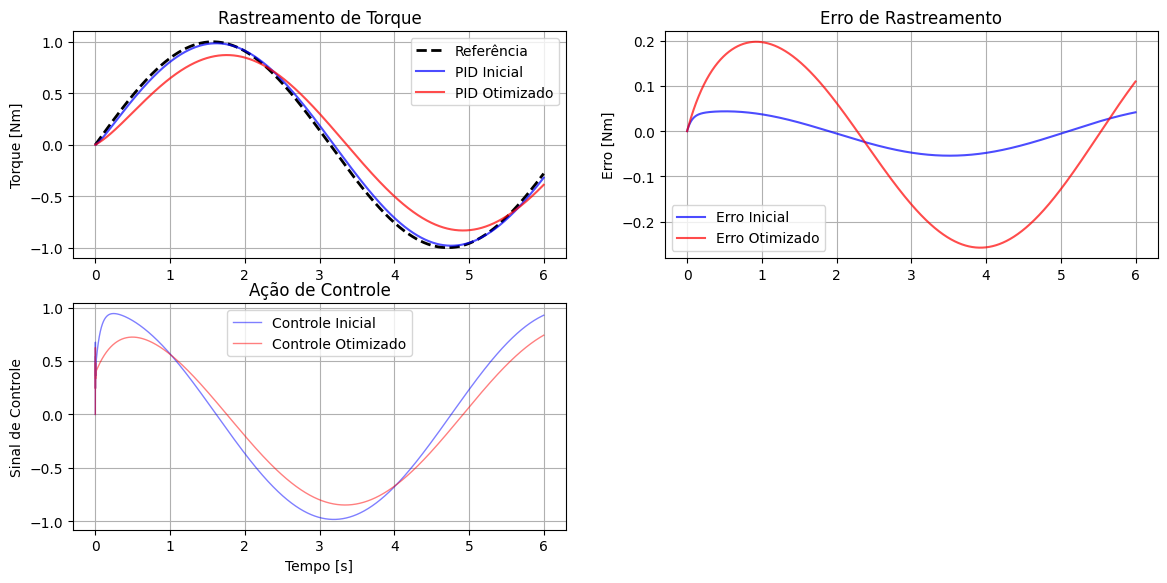

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import time
import random

# --- CLASSE PID ---
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err: list):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.err = err # Referencia para a lista externa
        self.integral = 0.0
        self.last_error = 0.0
        self.time_init = True

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value

        # Termo Proporcional
        P_term = self.Kp * error

        # Termo Integral
        if not self.time_init:
            self.integral += error * self.dt
            I_term = self.Ki * self.integral
        else:
            I_term = 0.0
            self.time_init = False

        # Termo Derivativo
        derivative = (error - self.last_error) / self.dt
        D_term = self.Kd * derivative

        self.last_error = error

        # Salva o erro na lista externa
        self.err.append(error)

        u = P_term + I_term + D_term
        return u

class Metrics:
    def __init__(self, err: list):
        self.err = err

    def mae(self, err: list) -> float:
        return np.mean(np.abs(err))

    def itae(self, err: list, t: np.ndarray) -> float:
        return (np.mean(np.abs(err) * t))

    def mse(self, err: list) -> float:
        return np.mean(np.square(err))

    def _epsilon1(self, SC_k: list) -> float:
        return np.mean(SC_k)

    def _epsilon2(self, SC_k: list, eps_1) -> float:
        result = []
        for i in range(len(SC_k)):
            result.append(np.square(SC_k[i] - eps_1))
        return np.mean(result)

    def _epsilon3(self, err: list) -> float:
        return self.mse(err)

    def goodhart_index(self, c1: float, c2: float, c3: float, SC_k: list)-> float:
        first_idx = c1 * self._epsilon1(SC_k)
        second_idx = c2 * self._epsilon2(SC_k, self._epsilon1(SC_k))
        third_idx = c3 * self._epsilon3(self.err)

        bom_coracao = first_idx + second_idx + third_idx
        return bom_coracao


# --- PARÂMETROS GLOBAIS ---
tf = 6.0
ts_ms = 1.0
n = int((1 / (ts_ms / 1000.0))*tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

# Parâmetros do Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# Referências
torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

# --- GANHOS PID INICIAIS ---
Kp_inicial = 20.0
Ki_inicial = 15.0
Kd_inicial = 0.5

print("="*70)
print(" OTIMIZAÇÃO PID COM ALGORITMO GENÉTICO")
print("="*70)
print("\n--- PARÂMETROS DO SISTEMA ---")
print(f"Motor: a = {a}, k = {k}")
print(f"Erros de modelagem: a_error = {a_model_error}, k_error = {k_model_error}")
print(f"\nPID INICIAL: Kp = {Kp_inicial}, Ki = {Ki_inicial}, Kd = {Kd_inicial}")

# --- MODELO DO MOTOR ---
def dc_motor_model(x1_m, u):
    dx1_m = -(a+a_model_error)*(k+k_model_error)*x1_m + (k+k_model_error)*u
    y1_m = x1_m
    return dx1_m

def connected_systems_model(states, t, dc_volts):
    x1_m, _ = states
    taup = dc_motor_model(x1_m, dc_volts)
    out_states = [taup, 0.0]
    return out_states

# --- FUNÇÃO DE SIMULAÇÃO ---
def run_simulation(kp, ki, kd):
    """Executa simulação completa com ganhos PID fornecidos"""
    err_list = []
    SC_k_list = []

    pid = PIDController(kp, ki, kd, t_sim_step, err_list)
    states0 = [0, 0]
    current_tau = states0[0]

    for i in range(n-1):
        tau_ref_i = torque_ref[i]

        # Calcula ação de controle
        dc_volts = pid.calculate_control_action(tau_ref_i, current_tau)

        # Simula sistema
        out_states = odeint(connected_systems_model, states0, [0.0, tf/n], args=(dc_volts,))

        # Armazena sinal de controle
        SC_k_list.append(dc_motor_model(states0[0], dc_volts))

        # Atualiza estados
        states0 = out_states[-1,:]
        current_tau = states0[0]

    return err_list, SC_k_list

# --- FUNÇÃO FITNESS ---
def fitness_function(individual):
    """Calcula fitness (Goodhart Index) para um conjunto de ganhos PID"""
    kp, ki, kd = individual

    # Restrição: Ganhos negativos proibidos
    if kp < 0 or ki < 0 or kd < 0:
        return 1e9

    try:
        # Executa simulação
        err_hist, SC_k_hist = run_simulation(kp, ki, kd)

        # Calcula métricas
        m = Metrics(err_hist)
        score = m.goodhart_index(0.33, 0.33, 0.34, SC_k_hist)

        # Verifica valores inválidos
        if np.isnan(score) or np.isinf(score):
            return 1e9

        return score
    except Exception as e:
        return 1e9

# --- ALGORITMO GENÉTICO ---
def genetic_algorithm(initial_pid, pop_size=30, generations=20, mutation_rate=0.2):
    """
    Otimiza ganhos PID usando Algoritmo Genético

    Args:
        initial_pid: [Kp, Ki, Kd] inicial
        pop_size: Tamanho da população
        generations: Número de gerações
        mutation_rate: Taxa de mutação
    """
    print("\n" + "="*70)
    print(" INICIANDO ALGORITMO GENÉTICO")
    print("="*70)
    print(f"População: {pop_size} indivíduos")
    print(f"Gerações: {generations}")
    print(f"Taxa de mutação: {mutation_rate*100}%")
    print(f"Indivíduo inicial: Kp={initial_pid[0]}, Ki={initial_pid[1]}, Kd={initial_pid[2]}")

    # Inicialização da população ao redor dos valores iniciais
    population = []

    # Adiciona o indivíduo inicial
    population.append(initial_pid.copy())

    # Gera resto da população com variações
    for _ in range(pop_size - 1):
        individual = [
            initial_pid[0] + random.gauss(0, initial_pid[0] * 0.3),  # ±30% do Kp
            initial_pid[1] + random.gauss(0, initial_pid[1] * 0.3),  # ±30% do Ki
            initial_pid[2] + random.gauss(0, initial_pid[2] * 0.3)   # ±30% do Kd
        ]
        # Garante valores positivos
        individual = [max(0.1, g) for g in individual]
        population.append(individual)

    best_global_ind = None
    best_global_score = float('inf')
    history = []

    print("\n--- EVOLUÇÃO ---\n")

    for gen in range(generations):
        # Avalia população
        scored_pop = []
        for ind in population:
            score = fitness_function(ind)
            scored_pop.append((ind, score))

        # Ordena por fitness (menor é melhor)
        scored_pop.sort(key=lambda x: x[1])

        # Atualiza melhor global
        best_gen = scored_pop[0]
        if best_gen[1] < best_global_score:
            best_global_score = best_gen[1]
            best_global_ind = best_gen[0]

        # Armazena histórico
        history.append({
            'generation': gen + 1,
            'best_score': best_gen[1],
            'avg_score': np.mean([x[1] for x in scored_pop]),
            'best_kp': best_gen[0][0],
            'best_ki': best_gen[0][1],
            'best_kd': best_gen[0][2]
        })

        print(f"Geração {gen+1:2d}: Score={best_gen[1]:.4f} | "
              f"Kp={best_gen[0][0]:.2f}, Ki={best_gen[0][1]:.2f}, Kd={best_gen[0][2]:.2f}")

        # Seleção (melhor 50%)
        parents = [x[0] for x in scored_pop[:pop_size//2]]

        # Nova população com elitismo
        new_pop = [best_gen[0]]  # Melhor indivíduo sempre sobrevive

        # Reprodução
        while len(new_pop) < pop_size:
            # Seleção de pais
            p1, p2 = random.sample(parents, 2)

            # Crossover (combinação linear)
            alpha = random.random()
            child = [alpha*g1 + (1-alpha)*g2 for g1, g2 in zip(p1, p2)]

            # Mutação
            if random.random() < mutation_rate:
                idx = random.randint(0, 2)
                mutation_strength = child[idx] * 0.2  # 20% do valor
                child[idx] += random.gauss(0, mutation_strength)
                child[idx] = max(0.1, child[idx])  # Garante positivo

            new_pop.append(child)

        population = new_pop

    print("\n" + "="*70)
    print(" OTIMIZAÇÃO CONCLUÍDA")
    print("="*70)

    return best_global_ind, history

# --- EXECUÇÃO DO ALGORITMO GENÉTICO ---
start_time = time.time()

best_pid, evolution_history = genetic_algorithm(
    initial_pid=[Kp_inicial, Ki_inicial, Kd_inicial],
    pop_size=30,
    generations=20,
    mutation_rate=0.2
)

elapsed_time = time.time() - start_time

Kp_opt, Ki_opt, Kd_opt = best_pid

print(f"\nTempo de otimização: {elapsed_time:.2f} segundos")
print(f"\nPID OTIMIZADO: Kp={Kp_opt:.2f}, Ki={Ki_opt:.2f}, Kd={Kd_opt:.2f}")

# --- COMPARAÇÃO: PID INICIAL vs PID OTIMIZADO ---
print("\n" + "="*70)
print(" SIMULAÇÃO COMPARATIVA")
print("="*70)

# Simula com PID inicial
print("\nSimulando com PID inicial...")
err_inicial, SC_k_inicial = run_simulation(Kp_inicial, Ki_inicial, Kd_inicial)

# Recria estados para plotagem (PID Inicial)
pid_inicial_plot = PIDController(Kp_inicial, Ki_inicial, Kd_inicial, t_sim_step, [])
states_inicial = np.zeros((n-1, 2))
states0 = [0, 0]
current_tau = states0[0]

for i in range(n-1):
    tau_ref_i = torque_ref[i]
    dc_volts = pid_inicial_plot.calculate_control_action(tau_ref_i, current_tau)
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n], args=(dc_volts,))
    states0 = out_states[-1,:]
    states_inicial[i] = out_states[-1,:]
    current_tau = states0[0]

# Simula com PID otimizado
print("Simulando com PID otimizado...")
err_otimizado, SC_k_otimizado = run_simulation(Kp_opt, Ki_opt, Kd_opt)

# Recria estados para plotagem (PID Otimizado)
pid_otimizado_plot = PIDController(Kp_opt, Ki_opt, Kd_opt, t_sim_step, [])
states_otimizado = np.zeros((n-1, 2))
states0 = [0, 0]
current_tau = states0[0]

for i in range(n-1):
    tau_ref_i = torque_ref[i]
    dc_volts = pid_otimizado_plot.calculate_control_action(tau_ref_i, current_tau)
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n], args=(dc_volts,))
    states0 = out_states[-1,:]
    states_otimizado[i] = out_states[-1,:]
    current_tau = states0[0]

# --- CÁLCULO DE MÉTRICAS ---
m_inicial = Metrics(err_inicial)
mae_inicial = m_inicial.mae(err_inicial)
itae_inicial = m_inicial.itae(err_inicial, time_vector[:-1])
mse_inicial = m_inicial.mse(err_inicial)
gh_inicial = m_inicial.goodhart_index(0.33, 0.33, 0.34, SC_k_inicial)

m_otimizado = Metrics(err_otimizado)
mae_otimizado = m_otimizado.mae(err_otimizado)
itae_otimizado = m_otimizado.itae(err_otimizado, time_vector[:-1])
mse_otimizado = m_otimizado.mse(err_otimizado)
gh_otimizado = m_otimizado.goodhart_index(0.33, 0.33, 0.34, SC_k_otimizado)

# --- RESULTADOS ---
print("\n" + "="*70)
print(" RESULTADOS FINAIS")
print("="*70)
print("\n--- MÉTRICAS PID INICIAL ---")
print(f"MAE:            {mae_inicial:.6f}")
print(f"ITAE:           {itae_inicial:.6f}")
print(f"MSE:            {mse_inicial:.6f}")
print(f"Goodhart Index: {gh_inicial:.6f}")

print("\n--- MÉTRICAS PID OTIMIZADO ---")
print(f"MAE:            {mae_otimizado:.6f}")
print(f"ITAE:           {itae_otimizado:.6f}")
print(f"MSE:            {mse_otimizado:.6f}")
print(f"Goodhart Index: {gh_otimizado:.6f}")


# --- PLOTAGEM ---
plt.rcParams['axes.grid'] = True
fig = plt.figure(figsize=(14, 10))

# Gráfico 1: Rastreamento de Torque
plt.subplot(3, 2, 1)
plt.plot(time_vector[:-1], torque_ref[:-1], 'k--', linewidth=2, label='Referência')
plt.plot(time_vector[:-1], states_inicial[:,0], 'b', linewidth=1.5, alpha=0.7, label='PID Inicial')
plt.plot(time_vector[:-1], states_otimizado[:,0], 'r', linewidth=1.5, alpha=0.7, label='PID Otimizado')
plt.ylabel('Torque [Nm]')
plt.title('Rastreamento de Torque')
plt.legend()
plt.grid(True)

# Gráfico 2: Erro
plt.subplot(3, 2, 2)
plt.plot(time_vector[:-1], err_inicial, 'b', linewidth=1.5, alpha=0.7, label='Erro Inicial')
plt.plot(time_vector[:-1], err_otimizado, 'r', linewidth=1.5, alpha=0.7, label='Erro Otimizado')
plt.ylabel('Erro [Nm]')
plt.title('Erro de Rastreamento')
plt.legend()
plt.grid(True)

# Gráfico 3: Sinal de Controle
plt.subplot(3, 2, 3)
plt.plot(time_vector[:-1], SC_k_inicial, 'b', linewidth=1, alpha=0.5, label='Controle Inicial')
plt.plot(time_vector[:-1], SC_k_otimizado, 'r', linewidth=1, alpha=0.5, label='Controle Otimizado')
plt.ylabel('Sinal de Controle')
plt.xlabel('Tempo [s]')
plt.title('Ação de Controle')
plt.legend()
plt.grid(True)

# Gráfico 4: Evolução do Fitness
#plt.subplot(3, 2, 4)
#generations = [h['generation'] for h in evolution_history]
#best_scores = [h['best_score'] for h in evolution_history]
#avg_scores = [h['avg_score'] for h in evolution_history]
#plt.plot(generations, best_scores, 'r-o', linewidth=2, markersize=4, label='Melhor')
#plt.plot(generations, avg_scores, 'b--', linewidth=1.5, alpha=0.6, label='Média')
#plt.ylabel('Goodhart Index')
#plt.xlabel('Geração')
#plt.title('Evolução do Fitness (AG)')
#plt.legend()
#plt.grid(True)

# Gráfico 5: Evolução dos Ganhos
#plt.subplot(3, 2, 5)
#kps = [h['best_kp'] for h in evolution_history]
#kis = [h['best_ki'] for h in evolution_history]
#kds = [h['best_kd'] for h in evolution_history]
#plt.plot(generations, kps, 'r-', linewidth=2, label='Kp', marker='o', markersize=3)
#plt.plot(generations, kis, 'g-', linewidth=2, label='Ki', marker='s', markersize=3)
#plt.plot(generations, kds, 'b-', linewidth=2, label='Kd', marker='^', markersize=3)
#plt.ylabel('Valor do Ganho')
#plt.xlabel('Geração')
#plt.title('Evolução dos Ganhos PID')
#plt.legend()
#plt.grid(True)

# Gráfico 6: Comparação de Métricas
#plt.subplot(3, 2, 6)
#metrics_names = ['MAE', 'MSE', 'ITAE', 'Goodhart']
#inicial_vals = [mae_inicial, mse_inicial, itae_inicial, gh_inicial]
#otimizado_vals = [mae_otimizado, mse_otimizado, itae_otimizado, gh_otimizado]

# Normaliza para visualização
inicial_norm = [v/max(inicial_vals) for v in inicial_vals]
otimizado_norm = [v/max(inicial_vals) for v in otimizado_vals]

x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, inicial_norm, width, label='PID Inicial', color='b', alpha=0.7)
plt.bar(x + width/2, otimizado_norm, width, label='PID Otimizado', color='r', alpha=0.7)
plt.ylabel('Valor Normalizado')
plt.title('Comparação de Métricas')
plt.xticks(x, metrics_names)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

#Método dos Poliedros Flexíveis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time

Iniciando Otimização PID via Poliedros Flexíveis (Nelder-Mead)...
Iter 1: Score=0.0350 | PID: [16.   5.   0.1]
Iter 2: Score=0.0350 | PID: [16.   5.   0.1]
Iter 3: Score=0.0350 | PID: [16.   5.   0.1]
Iter 4: Score=0.0350 | PID: [16.   5.   0.1]
Iter 5: Score=0.0311 | PID: [18.63  4.2   0.55]
Iter 6: Score=0.0241 | PID: [24.74  4.27  0.26]
Iter 7: Score=0.0235 | PID: [24.91  1.26  0.15]
Iter 8: Score=0.0201 | PID: [29.52  1.48  0.54]
Iter 9: Score=0.0174 | PID: [34.16  0.47  0.08]
Iter 10: Score=0.0174 | PID: [34.16  0.47  0.08]
Iter 11: Score=0.0170 | PID: [35.63  1.82  0.43]
Iter 12: Score=0.0170 | PID: [35.63  1.82  0.43]
Iter 13: Score=0.0163 | PID: [3.708e+01 1.350e+00 1.000e-02]
Iter 14: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 15: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 16: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 17: Score=0.0136 | PID: [46.5   1.26  0.53]
Iter 18: Score=0.0117 | PID: [53.75  0.6   0.29]
Iter 19: Score=0.0117 | P

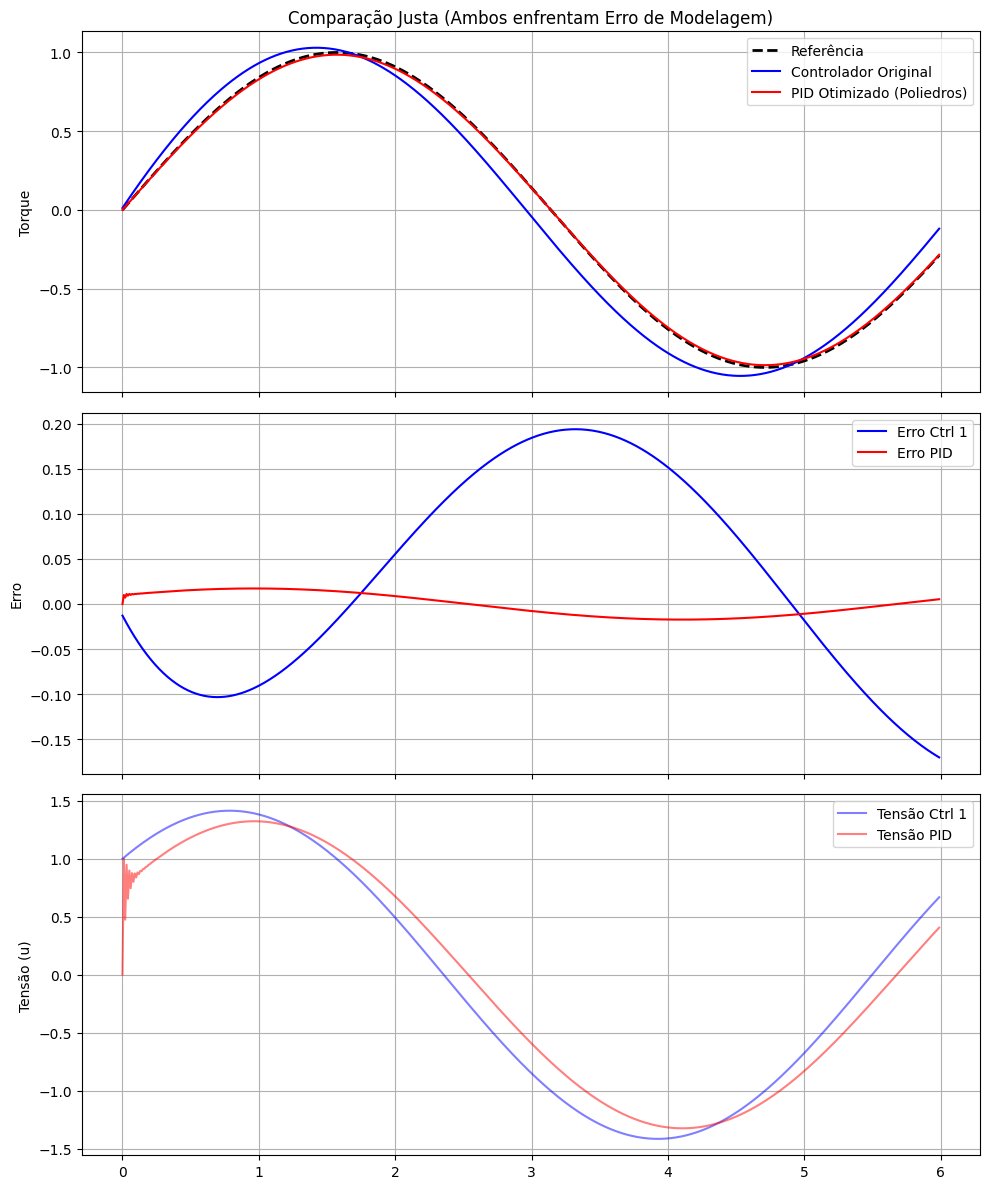

Goodhart Index Final -> Original: 0.0715 | PID (Poliedros): 0.0087


In [ ]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err_storage=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.err_storage = err_storage

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        if self.err_storage is not None:
            self.err_storage.append(error)
        return output

class Metrics:
    def __init__(self, error_history):
        self.error_history = np.array(error_history)

    def goodhart_index(self, w1, w2, w3, control_effort):
        mse = np.mean(self.error_history**2)
        max_err = np.max(np.abs(self.error_history)) if len(self.error_history) > 0 else 0
        mean_effort = np.mean(np.abs(control_effort)) if len(control_effort) > 0 else 0
        return (w1 * mse) + (w2 * max_err) + (w3 * mean_effort * 0.01)

tf = 6.0
ts_ms = 10.0
n = int((1 / (ts_ms / 1000.0))*tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

a = 1.0
k = 1.0
a_model_error = 0.1
k_model_error = 0.3

def motor_physics_real(states, t, u):
    x1_m, _ = states
    dx1_m = -(a + a_model_error)*(k + k_model_error)*x1_m + (k + k_model_error)*u
    return [dx1_m, 0.0]

def run_simulation(kp, ki, kd):
    local_err = []
    pid = PIDController(kp, ki, kd, t_sim_step, local_err)
    local_SC_k = []
    curr_state = [0.0, 0.0]

    for i in range(n-1):
        ref = torque_ref[i]
        meas = curr_state[0]

        u = pid.calculate_control_action(ref, meas)
        u = np.clip(u, -200, 200)

        local_SC_k.append(u)

        out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
        curr_state = out[-1, :]

    return local_err, local_SC_k

def fitness_function(individual):
    kp, ki, kd = individual

    if kp < 0 or ki < 0 or kd < 0: return 1e9

    try:
        err_hist, u_hist = run_simulation(kp, ki, kd)
        m = Metrics(err_hist)

        score = m.goodhart_index(0.4, 0.4, 0.2, u_hist)

        if np.isnan(score) or np.isinf(score): return 1e9
        return score
    except:
        return 1e9

def flexible_polyhedron_method():
    alpha = 1.0
    gamma = 2.0
    rho = 0.5
    sigma = 0.5

    max_iter = 30
    tol = 1e-4

    x0 = np.array([10.0, 5.0, 0.1])

    simplex = [x0]
    for i in range(len(x0)):
        x = np.array(x0, copy=True)
        x[i] = x[i] * 1.5 + 1.0
        simplex.append(x)

    print(f"Iniciando Otimização PID via Poliedros Flexíveis (Nelder-Mead)...")

    for k in range(max_iter):
        simplex.sort(key=lambda x: fitness_function(x))
        best = simplex[0]
        worst = simplex[-1]
        best_score = fitness_function(best)

        print(f"Iter {k+1}: Score={best_score:.4f} | PID: {np.round(best, 2)}")

        if np.linalg.norm(simplex[0] - simplex[-1]) < tol:
            break

        centroid = np.mean(simplex[:-1], axis=0)

        xr = centroid + alpha * (centroid - worst)
        score_r = fitness_function(xr)

        if fitness_function(best) <= score_r < fitness_function(simplex[-2]):
            simplex[-1] = xr

        elif score_r < fitness_function(best):
            xe = centroid + gamma * (xr - centroid)
            if fitness_function(xe) < score_r:
                simplex[-1] = xe
            else:
                simplex[-1] = xr

        else:
            xc = centroid + rho * (worst - centroid)
            score_c = fitness_function(xc)
            if score_c < fitness_function(worst):
                simplex[-1] = xc
            else:
                for i in range(1, len(simplex)):
                    simplex[i] = best + sigma * (simplex[i] - best)

    return simplex[0]

best_pid = flexible_polyhedron_method()
Kp_opt, Ki_opt, Kd_opt = best_pid

print(f"\n--- Otimização Concluída ---")
print(f"Melhores Ganhos: Kp={Kp_opt:.4f}, Ki={Ki_opt:.4f}, Kd={Kd_opt:.4f}")

k_c1 = 1.0
SC_k_1 = []
err_1 = []
states_1 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]

def motor_controller_1(tau, tau_ref, taup_ref):
    v = taup_ref - k_c1*(tau - tau_ref)
    u = (a*tau + v)/k
    return u

for i in range(n-1):
    u = motor_controller_1(curr_state[0], torque_ref[i], torquep_ref[i])
    SC_k_1.append(u)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_1[i] = curr_state
    err_1.append(torque_ref[i] - states_1[i, 0])

err_2, SC_k_2 = run_simulation(Kp_opt, Ki_opt, Kd_opt)

pid_final_plot = PIDController(Kp_opt, Ki_opt, Kd_opt, t_sim_step, [])
states_2 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]
for i in range(n-1):
    u = pid_final_plot.calculate_control_action(torque_ref[i], curr_state[0])
    u = np.clip(u, -200, 200)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_2[i] = curr_state

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador Original')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label='PID Otimizado (Poliedros)')
axs[0].set_ylabel('Torque')
axs[0].legend()
axs[0].set_title('Comparação Justa (Ambos enfrentam Erro de Modelagem)')

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro PID')
axs[1].set_ylabel('Erro')
axs[1].legend()

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.5)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão PID', alpha=0.5)
axs[2].set_ylabel('Tensão (u)')
axs[2].legend()

plt.tight_layout()
plt.show()

m1 = Metrics(err_1)
gh1 = m1.goodhart_index(0.33, 0.33, 0.34, SC_k_1)
m2 = Metrics(err_2)
gh2 = m2.goodhart_index(0.33, 0.33, 0.34, SC_k_2)

print(f"Goodhart Index Final -> Original: {gh1:.4f} | PID (Poliedros): {gh2:.4f}")

#Otimização por Enxame de Partículas (PSO)

Iniciando Otimização PID via PSO (Enxame de Partículas)...
Iter 1/20: Melhor Score Global = 1.2281 | PID: [22.86 22.83  2.53]
Iter 2/20: Melhor Score Global = 1.2281 | PID: [22.86 22.83  2.53]
Iter 3/20: Melhor Score Global = 1.2280 | PID: [22.83 22.5   2.5 ]
Iter 4/20: Melhor Score Global = 1.2280 | PID: [22.83 22.49  2.5 ]
Iter 5/20: Melhor Score Global = 1.2278 | PID: [ 0.   22.22  4.99]
Iter 6/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 7/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 8/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 9/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 10/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 11/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 12/20: Melhor Score Global = 1.2272 | PID: [ 4.09 13.53  5.16]
Iter 13/20: Melhor Score Global = 0.0465 | PID: [ 1.99 28.45  0.  ]
Iter 14/20: Melhor Score Global = 0.0228 | PID: [ 8.12 60.94  0.  

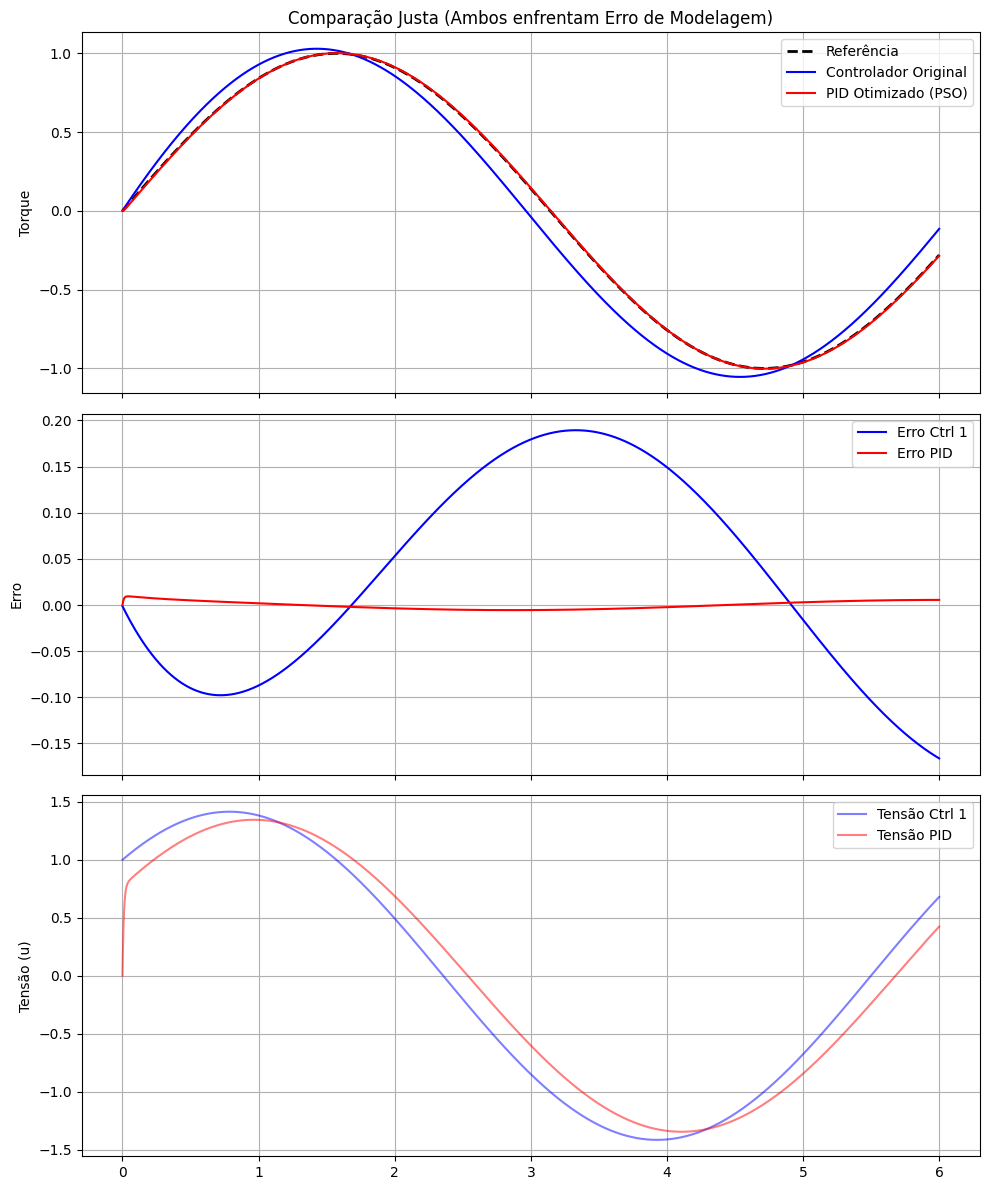

Goodhart Index Final -> Original: 0.0698 | PID (PSO): 0.0061


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err_storage=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.err_storage = err_storage

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        if self.err_storage is not None:
            self.err_storage.append(error)
        return output

class Metrics:
    def __init__(self, error_history):
        self.error_history = np.array(error_history)

    def goodhart_index(self, w1, w2, w3, control_effort):
        mse = np.mean(self.error_history**2)
        max_err = np.max(np.abs(self.error_history)) if len(self.error_history) > 0 else 0
        mean_effort = np.mean(np.abs(control_effort)) if len(control_effort) > 0 else 0
        return (w1 * mse) + (w2 * max_err) + (w3 * mean_effort * 0.01)

tf = 6.0
ts_ms = 1.0
n = int((1 / (ts_ms / 1000.0))*tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

a = 1.0
k = 1.0
a_model_error = 0.1
k_model_error = 0.3

def motor_physics_real(states, t, u):
    x1_m, _ = states
    dx1_m = -(a + a_model_error)*(k + k_model_error)*x1_m + (k + k_model_error)*u
    return [dx1_m, 0.0]

def run_simulation(kp, ki, kd):
    local_err = []
    pid = PIDController(kp, ki, kd, t_sim_step, local_err)
    local_SC_k = []
    curr_state = [0.0, 0.0]

    for i in range(n-1):
        ref = torque_ref[i]
        meas = curr_state[0]

        u = pid.calculate_control_action(ref, meas)
        u = np.clip(u, -200, 200)

        local_SC_k.append(u)

        out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
        curr_state = out[-1, :]

    return local_err, local_SC_k

def fitness_function(individual):
    kp, ki, kd = individual

    if kp < 0 or ki < 0 or kd < 0: return 1e9

    try:
        err_hist, u_hist = run_simulation(kp, ki, kd)
        m = Metrics(err_hist)

        score = m.goodhart_index(0.33, 0.33, 0.34, u_hist)

        if np.isnan(score) or np.isinf(score): return 1e9
        return score
    except:
        return 1e9

def particle_swarm_optimization():
    num_particles = 15
    max_iter = 20

    w = 0.7
    c1 = 1.5
    c2 = 1.5

    limits = [(0.0, 50.0), (0.0, 50.0), (0.0, 5.0)]

    positions = []
    velocities = []
    p_best_pos = []
    p_best_scores = []

    for _ in range(num_particles):
        pos = np.array([
            random.uniform(limits[0][0], limits[0][1]),
            random.uniform(limits[1][0], limits[1][1]),
            random.uniform(limits[2][0], limits[2][1])
        ])
        positions.append(pos)
        velocities.append(np.zeros(3))
        p_best_pos.append(pos.copy())
        p_best_scores.append(float('inf'))

    g_best_pos = positions[0].copy()
    g_best_score = float('inf')

    print(f"Iniciando Otimização PID via PSO (Enxame de Partículas)...")

    for t in range(max_iter):
        for i in range(num_particles):
            score = fitness_function(positions[i])

            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_pos[i] = positions[i].copy()

                if score < g_best_score:
                    g_best_score = score
                    g_best_pos = positions[i].copy()

        print(f"Iter {t+1}/{max_iter}: Melhor Score Global = {g_best_score:.4f} | PID: {np.round(g_best_pos, 2)}")

        for i in range(num_particles):
            r1 = random.random()
            r2 = random.random()

            velocities[i] = (w * velocities[i]) + \
                            (c1 * r1 * (p_best_pos[i] - positions[i])) + \
                            (c2 * r2 * (g_best_pos - positions[i]))

            positions[i] = positions[i] + velocities[i]

            positions[i] = np.maximum(positions[i], 0.0)

    return g_best_pos

best_pid = particle_swarm_optimization()
Kp_opt, Ki_opt, Kd_opt = best_pid

print(f"\n--- Otimização Concluída ---")
print(f"Melhores Ganhos: Kp={Kp_opt:.4f}, Ki={Ki_opt:.4f}, Kd={Kd_opt:.4f}")

k_c1 = 1.0
SC_k_1 = []
err_1 = []
states_1 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]

def motor_controller_1(tau, tau_ref, taup_ref):
    v = taup_ref - k_c1*(tau - tau_ref)
    u = (a*tau + v)/k
    return u

for i in range(n-1):
    u = motor_controller_1(curr_state[0], torque_ref[i], torquep_ref[i])
    SC_k_1.append(u)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_1[i] = curr_state
    err_1.append(torque_ref[i] - states_1[i, 0])

err_2, SC_k_2 = run_simulation(Kp_opt, Ki_opt, Kd_opt)

pid_final_plot = PIDController(Kp_opt, Ki_opt, Kd_opt, t_sim_step, [])
states_2 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]
for i in range(n-1):
    u = pid_final_plot.calculate_control_action(torque_ref[i], curr_state[0])
    u = np.clip(u, -200, 200)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_2[i] = curr_state

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador Original')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label='PID Otimizado (PSO)')
axs[0].set_ylabel('Torque')
axs[0].legend()
axs[0].set_title('Comparação Justa (Ambos enfrentam Erro de Modelagem)')

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro PID')
axs[1].set_ylabel('Erro')
axs[1].legend()

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.5)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão PID', alpha=0.5)
axs[2].set_ylabel('Tensão (u)')
axs[2].legend()

plt.tight_layout()
plt.show()

m1 = Metrics(err_1)
gh1 = m1.goodhart_index(0.33, 0.33, 0.34, SC_k_1)
m2 = Metrics(err_2)
gh2 = m2.goodhart_index(0.33, 0.33, 0.34, SC_k_2)

print(f"Goodhart Index Final -> Original: {gh1:.4f} | PID (PSO): {gh2:.4f}")